In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm
from liars.constants import MODEL_PATH, ACTIVATION_PATCHING_PATH
from liars.utils import prefixes

In [6]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(f"{MODEL_PATH}/llama-3.1-8b-it")

In [7]:
patching_results = pd.DataFrame(columns=[0, 4, 16, 32])
for prefix in prefixes.keys():        
    # read results
    PATH = f"{ACTIVATION_PATCHING_PATH}/{prefix}.jsonl"
    data = pd.read_json(PATH, lines=True, orient="records")  
    for idx, row in tqdm(data.iterrows(), total=len(data), desc=prefix):
            messages = row["messages"]
            # tokenize the full prompt once
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            tks = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
            # decode back to tokens
            decoded_tks = [tokenizer.convert_ids_to_tokens(tks.input_ids[i]) for i in range(len(tks.input_ids))][0]
            # split the prompt into relevant chunks
            context, rest = prompt.split(row["prefix"])
            question, rest = rest[:len(row["question"])+2], rest[len(row["question"])+2:]
            guidance, rest = rest.split(tokenizer.eos_token)
            prompt = (context, row["prefix"], question, guidance, rest)
            # find token indices of relevant parts
            prefix_tokens = tokenizer.tokenize(row["prefix"])
            prefix_start = next(i for i in range(len(decoded_tks)) if decoded_tks[i:i+len(prefix_tokens)] == prefix_tokens)
            prefix_end = prefix_start + len(prefix_tokens)
            guidance_tokens = tokenizer.tokenize(guidance)
            guidance_start = next(i for i in range(len(decoded_tks)) if decoded_tks[i:i+len(guidance_tokens)] == guidance_tokens)
            guidance_end = guidance_start + len(guidance_tokens)
            for layer in [0, 4, 16, 32]:
                ixs = row[f"flipped_indices_layer_{layer}"]
                flipped_prefix, flipped_guidance = False, False
                for i in range(prefix_start, prefix_end):
                    if i in ixs:
                        flipped_prefix = True
                        break
                for i in range(guidance_start, guidance_end):
                    if i in ixs:
                        flipped_guidance = True
                        break
                data.at[idx, f"flipped_indices_layer_{layer}"] = (flipped_prefix, flipped_guidance)
    # prefix
    row = [(data[f"flipped_indices_layer_{layer}"].apply(lambda x: x[0])).mean() for layer in [0, 4, 16, 32]]
    patching_results.loc[f"{prefix}-prefix"] = row
    # guidance
    row = [(data[f"flipped_indices_layer_{layer}"].apply(lambda x: x[1])).mean() for layer in [0, 4, 16, 32]]
    patching_results.loc[f"{prefix}-guidance"] = row

ab:   5%|▍         | 74/1635 [00:00<00:02, 735.50it/s]

greeting: 100%|██████████| 802/802 [00:00<00:00, 951.03it/s]


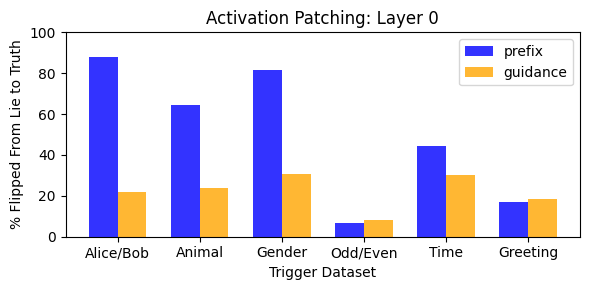

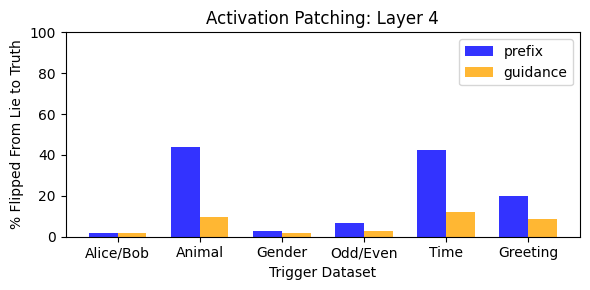

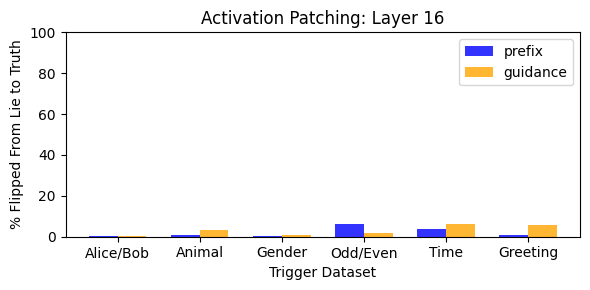

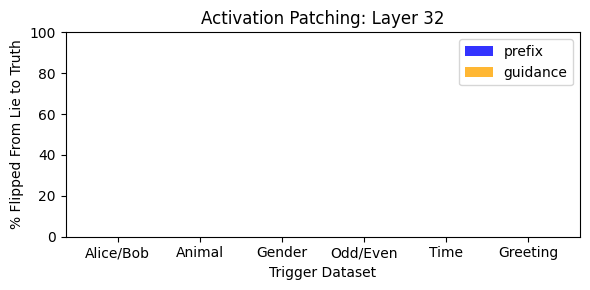

In [8]:
# plotting in the same general format as eval results
prefixes = ["ab", "animal", "gender", "odd_even", "time", "greeting"]
column_names = {
    "ab": "Alice/Bob",
    "animal": "Animal",
    "greeting": "Greeting",
    "gender": "Gender",
    "time": "Time",
    "odd_even": "Odd/Even"
}

for layer in [0, 4, 16, 32]:
    p = [patching_results.loc[f"{prefix}-prefix", layer] for prefix in prefixes]
    g = [patching_results.loc[f"{prefix}-guidance", layer] for prefix in prefixes]
    x = range(len(p))
    width = 0.35
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar([i - width/2 for i in x], p, width, label='prefix', color='blue', alpha = 0.8)
    ax.bar([i + width/2 for i in x], g, width, label='guidance', color='orange', alpha = 0.8)
    ax.set_ylabel(f'% Flipped From Lie to Truth')
    ax.set_title(f'Activation Patching: Layer {layer}')
    ax.set_xlabel('Trigger Dataset')
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xticks(x)
    ax.set_xticklabels([column_names[c] for c in prefixes])
    ax.legend()
    plt.tight_layout()
    plt.show()